In [5]:
from selenium import webdriver
from selenium.common.exceptions import WebDriverException
from PIL import Image
from io import BytesIO
import numpy as np
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import  time
from selenium.webdriver.common.keys import Keys
import os
from tqdm import tqdm
import shutil

In [2]:
options = webdriver.ChromeOptions()

options.add_argument('--headless')
options.add_argument('--no-sandbox')
# options.add_argument('--disable-dev-shm-usage')
# options.add_argument('--disable-blink-features=AutomationControlled')
# options.add_argument('--disable-extensions')
# options.add_argument('--disable-gpu')
# options.add_argument('--disable-infobars')
# options.add_argument('--disable-notifications')
# options.add_argument('--disable-popup-blocking')
# options.add_argument('--disable-web-security')
# options.add_argument('--ignore-certificate-errors')
# options.add_argument('--start-maximized')
# options.add_experimental_option('excludeSwitches', ['enable-automation', 'useAutomationExtension'])
# # Adding argument to disable the AutomationControlled flag 
# options.add_argument("--disable-blink-features=AutomationControlled") 
# # Exclude the collection of enable-automation switches 
# options.add_experimental_option("excludeSwitches", ["enable-automation"]) 
# # Turn-off userAutomationExtension 
# options.add_experimental_option("useAutomationExtension", False) 


wd = webdriver.Chrome(options=options)
wd.set_window_size(1080, 720)  # Adjust the window size here
# Changing the property of the navigator value for webdriver to undefined 
wd.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})") 

url='https://huggingface.co/spaces/OpenGVLab/InternVL'
wd.get(url)
time.sleep(3)
# 等待 JavaScript 加载完成
WebDriverWait(wd, 10).until(
    EC.presence_of_element_located((By.TAG_NAME, "body"))
)
print('load complete')

load complete


In [3]:
# url='https://huggingface.co/login'
# wd.get(url)
# # locate username
# username_input = WebDriverWait(wd, 10).until(
#         EC.presence_of_element_located((By.NAME, "username"))
#     )
# # 输入用户名
# username_input.clear()
# username_input.send_keys("devildc")
# # locate password
# passwd_input = WebDriverWait(wd, 10).until(
#     EC.presence_of_element_located((By.NAME, 'password'))
# )
# passwd_input.clear()
# passwd_input.send_keys('s5Fwq5VgFQUsruT')

# # 找到登录按钮并点击 /html/body/div/main/div/section/form/div[2]/button
# login_button = WebDriverWait(wd, 10).until(
#     EC.element_to_be_clickable((By.XPATH, "//button[@type='submit']"))
# )
# login_button.click()

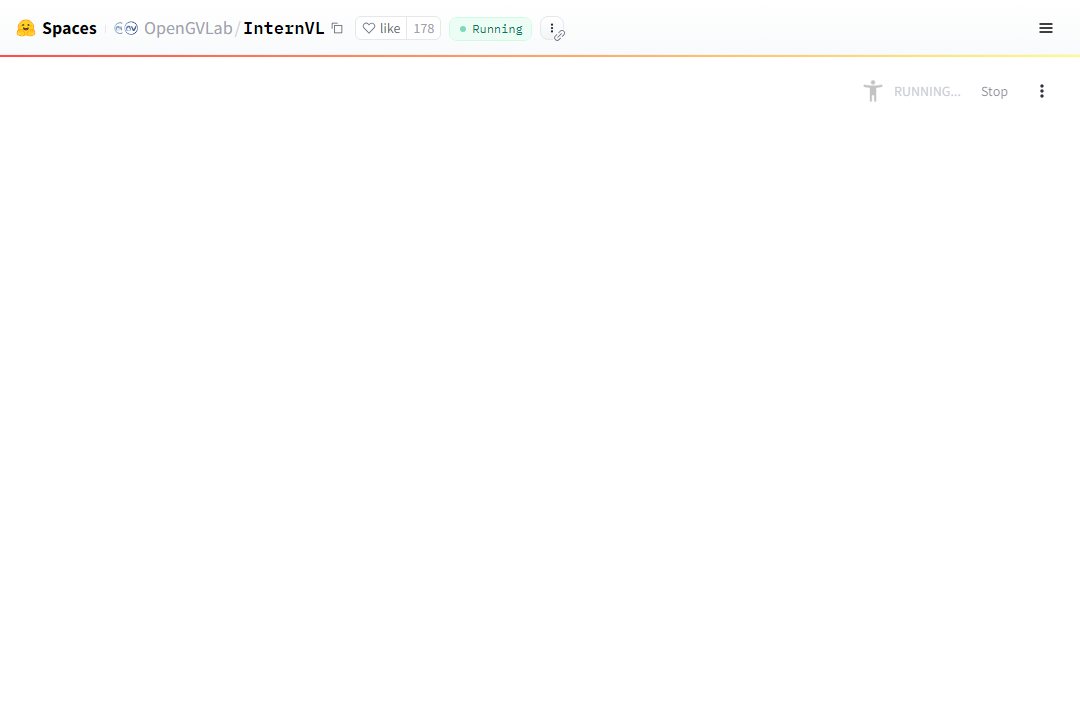

In [4]:
png=wd.get_screenshot_as_png()
png=BytesIO(png)
Image.open(png)

In [5]:
def locate_page(wd):
    # 使用 XPath 定位 iframe 元素
    # 等待 iframe 加载完成
    wd.switch_to.default_content()
    WebDriverWait(wd, 10).until(
        EC.frame_to_be_available_and_switch_to_it(
            (By.XPATH, "//iframe[contains(@src, 'opengvlab-internvl.hf.space')]")
        )
    )

    WebDriverWait(wd, 10).until(
        EC.frame_to_be_available_and_switch_to_it(
            (By.XPATH, "//iframe[contains(@src, 'https://internvl.opengvlab.com/')]")
        )
    )


def upload_file(wd, file_path):
    # upload file
    file_upload_btn = WebDriverWait(wd, 10).until(
        EC.presence_of_element_located(
            (By.XPATH, "//input[contains(@data-testid, 'stFileUploaderDropzoneInput')]")
        )
    )

    # 点击按钮后等待对话框出现
    # 可以使用 time.sleep() 或 WebDriverWait 等待
    time.sleep(2)

    file_upload_btn.send_keys(file_path)


def chat(wd, text: str):
    # send message
    text_area = WebDriverWait(wd, 10).until(
        EC.presence_of_element_located(
            (By.CSS_SELECTOR, "textarea[data-testid='stChatInputTextArea']")
        )
    )

    # 输入文本
    text_area.send_keys(text)

    # 模拟发送消息 (可选)
    text_area.send_keys(Keys.ENTER)


def get_chat(wd, prev_length) -> str:
    # 定位包含回答文本的 <div> 元素
    WebDriverWait(wd, 20).until(
        lambda d: (
            len(d.find_elements(By.CSS_SELECTOR, "div[data-testid='stChatMessageContent']")) 
            > prev_length 
            and len(d.find_elements(By.CSS_SELECTOR, "div[data-testid='stChatMessageContent']")) % 2 == 0
        )
    )
    answer_containers = WebDriverWait(wd, 10).until(
        EC.presence_of_all_elements_located(
            (By.CSS_SELECTOR, "div[data-testid='stChatMessageContent']")
        )
    )
    new_length = len(answer_containers)
    # time.sleep(2)
    if new_length % 2 != 0:
        return "fuckagain"
    
    WebDriverWait(wd, 5).until(
        lambda d: (
            d.find_elements(By.CSS_SELECTOR, "div[data-testid='stChatMessageContent']")[-1].find_element(By.TAG_NAME, "p").text[:8] != 'Thinking'
        )
    )
    
    try:
        text = (
            answer_containers[new_length - 1]
            .find_element(By.TAG_NAME, "p")
            .text
        )
    except:
        time.sleep(1)
        text = (
            answer_containers[new_length - 1]
            .find_element(By.TAG_NAME, "p")
            .text
        )
    return text, new_length


def clear_history(
    wd,
):
    # clear history
    # 定位 "Clear Chat History" 按钮
    clear_hisory_btn = WebDriverWait(wd, 10).until(
        EC.presence_of_all_elements_located(
            (By.CSS_SELECTOR, "div[data-testid='stHorizontalBlock']")
        )
    )[-1]
    try:
        clear_hisory_btn.find_element(By.TAG_NAME, "button").click()
    except Exception as e:
        refresh_page(wd)
        time.sleep(3)
        wd.switch_to.default_content()
        locate_page(wd)


def refresh_page(
    wd,
):
    wd.refresh()
    time.sleep(3)
    # 等待 JavaScript 加载完成
    WebDriverWait(wd, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
    print("load complete")


def choose_model(wd, model_name="InternVL2-26B"):
    selectbox = WebDriverWait(wd, 20).until(
        EC.presence_of_all_elements_located(
            (By.CSS_SELECTOR, "div[data-testid='stSelectbox']")
        )
    )[1]
    selectbox.click()

    option = WebDriverWait(wd, 10).until(
        EC.element_to_be_clickable((By.XPATH, f"//div[text()='{model_name}']"))
    )
    option.click()

In [6]:
# refresh_page(wd)
locate_page(wd)

In [7]:
base_path = r'E:\BaiduNetdiskDownload\all_cameras'
sub_dirs_paths = [os.path.join(base_path, sub_dir_path) for sub_dir_path in os.listdir(base_path)]

sub_sub_dirs=[]

for sub_dir_path in sub_dirs_paths:
    sub_sub_dirs += [os.path.join(sub_dir_path, sub_sub_dir_path) for sub_sub_dir_path in os.listdir(sub_dir_path)]

sub_sub_dirs_len = len(sub_sub_dirs)
for idx in range(sub_sub_dirs_len):
    if len(os.listdir(sub_sub_dirs[idx])) > 5:
        for sub_sub_dir in os.listdir(sub_sub_dirs[idx]):
            sub_sub_dirs.append(os.path.join(sub_sub_dirs[idx], sub_sub_dir))


In [4]:
def check_fd(fd):
    if not os.path.exists(fd):
        os.mkdir(fd)

def copy_img_fd(img, fd):
    check_fd(fd)
    shutil.copy(img, fd)

# copy_img_fd(r'E:\BaiduNetdiskDownload\cut\_2024_06_30_02_09_04_787.mp4_frame_20_block_0_2.jpg', r'E:\BaiduNetdiskDownload\fuck')

In [9]:
base = r'E:\BaiduNetdiskDownload'
prompt='Answer whether there is obvious water accumulation in the picture. If yes, answer yes, otherwise no. The requirement is that if there is obvious water accumulation, the depth of the water must exceed approximately 5cm.'
os.chdir(base)
length=0
model="InternVL2-8B"
for idx, sub_sub_dir in enumerate(sub_sub_dirs[136:]):
    try:
        choose_model(wd, model)
        if os.path.isdir(os.path.join(sub_sub_dir, os.listdir(sub_sub_dir)[0])):
            continue
        imgs = [os.path.join(sub_sub_dir, file_path) for file_path in os.listdir(sub_sub_dir)]
        target=None
        for img in imgs:
            if img.endswith('png'):
                target = img
                break
        if target == None:
            break
        upload_file(wd, target)
        chat(wd, prompt)
        res, length = get_chat(wd, length)
        print(f'{idx+1}=>{res}: {target}')
        if len(res) > 50:
            res = res[:50].strip()
        copy_img_fd(target, res)
        # if (idx+1) % 4 == 0:
        #     clear_history(wd)
        #     length=0
        #     time.sleep(3)
    except NotADirectoryError as e:
        print(f'{idx+1}: lost {target} {e}')
        copy_img_fd(target, 'lost' + '{e}' % e)
        refresh_page(wd)
        length=0
    except FileNotFoundError as e:
        print(f'{idx+1}: thinking lost {target} {e}')
        copy_img_fd(target, 'lost')
        # time.sleep(3)
    except Exception as e:
        print(f'{idx+1}: lost {target}: {e}')
        copy_img_fd(target, 'lost')
        clear_history(wd)
        length=0
        time.sleep(2)
    
    

1=>No, there is no obvious water accumulation in the picture. The ground appears to be dry with some wet spots but not enough depth exceeding approximately 5cm for it to constitute significant water accumulation.: E:\BaiduNetdiskDownload\all_cameras\09\09d22992-0c64-4d38-b99a-a4061df2dc7a\1_09d22992-0c64-4d38-b99a-a4061df2dc7a.png
2=>Yes, there is obvious water accumulation in the picture. The depth of the water appears to exceed approximately 5cm as indicated by visible puddles and standing water on the ground surface.: E:\BaiduNetdiskDownload\all_cameras\09\0a0bfe03-5b2e-4ce2-bb24-82f2ce580020\1_0a0bfe03-5b2e-4ce2-bb24-82f2ce580020.png
3=>No, there is no obvious water accumulation in the picture. The ground appears to be dry without visible puddles or standing water exceeding approximately 5cm deep.: E:\BaiduNetdiskDownload\all_cameras\09\0a17db5a-5b12-4027-8e78-992dab98c9db\1_0a17db5a-5b12-4027-8e78-992dab98c9db.png
4=>No, there is no obvious water accumulation in the picture. The g

TimeoutException: Message: 


In [ ]:

base_path= r'E:\BaiduNetdiskDownload\cut'
base = r'E:\BaiduNetdiskDownload'
os.chdir(base)
img_paths = [os.path.join(base_path, img_path) for img_path in os.listdir(base_path)]
# No, there is no obvious water accumulation in the picture

for idx, img in enumerate(img_paths[1372:]):
    try:
        # ensure model
        choose_model(wd)
        upload_file(wd, img)
        chat(wd, "You only need to answer whether there is water accumulation in the picture, that is, whether there is water accumulation or no water accumulation, just these words. And the requirement is that if there is water accumulation, the depth of the water must exceed approximately 5cm.")
        ans = get_chat(wd)
        copy_img_fd(img, ans)
        print(f'{ans}: {idx+1} {img}')
        if (idx+1) % 4 == 0:
            clear_history(wd)
            # time.sleep(3)
    except NotADirectoryError as e:
        print(f'{idx+1}: lost {img}')
        copy_img_fd(img, 'lost')
        refresh_page(wd)
        time.sleep(3)
        locate_page(wd)
        choose_model(wd)
    except FileNotFoundError as e:
        print(f'{idx+1}: thinking lost {img}')
        copy_img_fd(img, 'lost')
        # time.sleep(3)
    except:
        print(f'{idx+1}: lost {img}')
        copy_img_fd(img, 'lost')
        clear_history(wd)
        time.sleep(2)
        # time.sleep(3)
    # except NoSuchElementException as e:
        
    # except ElementNotInteractableException as e:
    #     clear_history(wd)
    #     time.sleep(3)

No water accumulation.: 1 E:\BaiduNetdiskDownload\cut\0039301_2_block_1_1.jpg
No water accumulation.: 2 E:\BaiduNetdiskDownload\cut\0039301_2_block_1_2.jpg
No water accumulation.: 3 E:\BaiduNetdiskDownload\cut\0039301_2_block_2_0.jpg
No water accumulation.: 4 E:\BaiduNetdiskDownload\cut\0039301_2_block_2_1.jpg
No water accumulation.: 5 E:\BaiduNetdiskDownload\cut\0039301_2_block_2_2.jpg
No water accumulation.: 6 E:\BaiduNetdiskDownload\cut\0039301_2_block_3_0.jpg
No water accumulation.: 7 E:\BaiduNetdiskDownload\cut\0039301_2_block_3_1.jpg
No water accumulation.: 8 E:\BaiduNetdiskDownload\cut\0039301_2_block_3_2.jpg
No water accumulation.: 9 E:\BaiduNetdiskDownload\cut\0039301_3_block_0_0.jpg
No water accumulation.: 10 E:\BaiduNetdiskDownload\cut\0039301_3_block_0_1.jpg
No water accumulation.: 11 E:\BaiduNetdiskDownload\cut\0039301_3_block_0_2.jpg
No water accumulation.: 12 E:\BaiduNetdiskDownload\cut\0039301_3_block_1_0.jpg
No water accumulation.: 13 E:\BaiduNetdiskDownload\cut\003930

In [1]:
import os
import shutil

In [3]:
base_path = r'E:\BaiduNetdiskDownload\cut_left'
all_imagess = [os.path.join(base_path, img) for img in os.listdir(base_path)]
print(f'all images are {len(all_imagess)}')

3855


In [8]:
os.chdir(r'E:\BaiduNetdiskDownload')
loop = enumerate(all_imagess)
for idx, img in tqdm(loop, total=len(all_imagess)):
    target_idx = (idx) % 4
    copy_img_fd(img, str(target_idx))

100%|██████████| 3855/3855 [01:49<00:00, 35.32it/s]


In [9]:
print(len(all_imagess) // 4)

963
